In [1]:
import os
x = []
for dirname, _, filenames in os.walk('/kaggle/input/mriimagesrgb/MRI_RGB_IMAGES'):
    for filename in filenames:
        x.append(os.path.join(dirname, filename))
        


In [2]:
print(os.getcwd())

/kaggle/working


#Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorboard
from datetime import datetime
from packaging import version
tensorboard.__version__ 

! mkdir ./callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = '../callbacks', 
                               histogram_freq = 0, 
                               write_graph = True, 
                              update_freq = 'epoch',
                                profile_batch = 0,
                               embeddings_freq = 0,
                              )

#to launch tensorboard, use this command in command line
#tensorboard --logdir=path_to_your_logs

#Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorboard
from datetime import datetime
from packaging import version
tensorboard.__version__ 

! mkdir ./callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = '../callbacks', 
                               histogram_freq = 0, 
                               write_graph = True, 
                              update_freq = 'epoch',
                                profile_batch = 0,
                               embeddings_freq = 0,
                              )

#to launch tensorboard, use this command in command line
#tensorboard --logdir=path_to_your_logs

In [3]:
# -*- coding: utf-8 -*-
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import glob
import imageio
import matplotlib.pyplot as plt

import numpy as np
#for FID score
from numpy import cov
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

import os
import PIL
import time
#from read_filelist import _read_label_file
from sklearn.utils import shuffle
from IPython import display

#from kaggle_secrets import UserSecretsClient
#user_secrets = UserSecretsClient()
#user_credential = user_secrets.get_gcloud_credential()
#user_secrets.set_tensorflow_credential(user_credential)

#user_secrets.set_tensorflow_credential(user_credential)

#from kaggle_datasets import KaggleDatasets
#GCS_DS_PATH = KaggleDatasets().get_gcs_path()
#filenames = tf.io.gfile.glob(GCS_DS_PATH + '/kaggle/input/mriimagesrgb/MRI_RGB_IMAGES/*.png')
filenames = tf.io.gfile.glob('/kaggle/input/mriimagesrgb/MRI_RGB_IMAGES/*.png')

#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

#get patient variables
#szpath = 'D:/Documents/Year 4 sem 1/FYP/Zephyr_RNN/ADNI_filelist_Jan2020.csv'
#filepaths, labels, ages, genders, study, subjid, waveid = _read_label_file(szpath, ',')

#Global variables
#image dimensions
IMG_H = 256
IMG_W = 256
IMG_C = 3

w_init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

def _read_label_file(file, delimiter):
#   BEGIN    
    f = open(file, "r")
    study = [] #0
    subjid = [] #1
    waveid = [] #3
    labels = []
    ages = []
    genders = []
    filepaths = []
    nFirst = 1;
    for line in f:#B1
        tokens = line.split(delimiter)
        if nFirst<1:#B2
            study.append(tokens[0])
            subjid.append(tokens[1])
            waveid.append(tokens[2])
            filepaths.append(tokens[0]+'_'+tokens[1]+'_'+tokens[2])
            dx = tokens[4]
            if dx == 'CN':
                labels.append(0)
            elif dx == 'EMCI':
                labels.append(2)
            elif dx == 'LMCI':
                labels.append(2)
            elif dx == 'MCI':
                labels.append(2)
            else:
                labels.append(3)
            ages.append(float(tokens[5]))
            genders.append(tokens[6]=='Male')
        else:
            nFirst = 0;
        #E2
    #E1
    genders = np.array(genders, dtype=float)
    labels = np.array(labels, dtype=float)
    ages = np.array(ages, dtype=float)
    return filepaths, labels, ages, genders, study, subjid, waveid
    

def load_image(image_path):
    
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image)
    image = tf.image.resize(image, (IMG_H, IMG_W))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5)/127.5 #normalize intensity image to (-1 and 1)
    
    return image

def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.list_files(f"{images_path}*.png")
    #dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters = num_filters,
        kernel_size = kernel_size,
        kernel_initializer=w_init,
        padding = "same",
        strides = strides,
        use_bias = False
    )(inputs)
    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha = 0.2)(x)
    return x

def conv_block(inputs, num_filters, kernel_size, padding = "same", strides = 2, activation = True):
    x = Conv2D(
        filters = num_filters,
        kernel_size = kernel_size,
        kernel_initializer=w_init,
        padding = padding,
        strides = strides
    )(inputs)
    
    if activation: #activation layer
        x = LeakyReLU(alpha = 0.2)(x)
        x = Dropout(0.3)(x)
    
    return x


def build_generator_model(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    noise  = Input(shape=(latent_dim,), name = "gen_noise_input")
    
    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, f[0] * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x, num_filters = f[i]* filters,
            kernel_size = 5,
            strides = 2,
            bn=True
        )
        
    x = conv_block(x,
        num_filters = 3,
        kernel_size = 5,
        strides = 1,
        activation = False
    )
    fake_output = Activation("tanh")(x)
    
    return Model(noise, fake_output, name="generator")

class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        
        #Training discriminator
        #Training discriminator twice for every generator train 
        #fake images labelled as 0, real labelled as 1
        for _ in range(2):
            #Fake images
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generator_images = self.generator(random_latent_vectors)
            generator_labels = tf.zeros((batch_size, 1)) 
            
            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generator_images)
                d1_loss = self.loss_fn(generator_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
            
            #Real images
            labels = tf.ones((batch_size, 1))
            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        #Training generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))
        
        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors)) #feeding generator into discriminator
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}
        
    
    

def build_discriminator_model():
    f = [2**i for i in range(4)]
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides
    
    image_input = Input(shape = (IMG_H, IMG_W, IMG_C), name = "images")
    x = image_input
    
    for i in range(0, 4):
        x = conv_block(x,
            num_filters = f[i] * filters,
            kernel_size = 5,
            strides = 2
        )
    
    x = Flatten()(x)
    x = Dense(1)(x)
    
    return Model(image_input, x, name="discriminator")
    
    

def save_plot(examples, epoch, n):
    examples = (examples +1)/2.0
    for i in range(n * n):
        
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])
    filename = f"./images/fake_image_epoch_{epoch+1}.png"
    #out_img = PIL.Image.fromarray(examples)
    #out_img.save(filename)
    plt.savefig(filename)
    #plt.show(examples)
    plt.close()
    
def display_img(examples, epoch, n):
    examples = (examples + 1)/2.0
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.axis("off")
        plt.imshow(examples[i])

def save_model(model, epoch):
    filename = f"./models/gmodel_epoch_{epoch+1}"
    model.save(filename)

def save_plot_one(examples, epoch, n):
    examples = (examples +1)/2.0
    #for i in range(n * n):
        
    #plt.subplot(n, n)
    plt.axis("off")
    plt.imshow(examples[1])
    filename = f"./images/fake_image_epoch_{epoch+1}.png"
    #out_img = PIL.Image.fromarray(examples)
    #out_img.save(filename)
    plt.savefig(filename)
    #plt.show(examples)
    plt.close()

if __name__ == '__main__':
    #Hyperparameters
    batch_size = 128
    latent_dim = 128
    num_epochs = 100
    
    #dataset
    images_path = f"/kaggle/input/mriimagesrgb/MRI_RGB_IMAGES/"
    print("Dataset Size = ", len(images_path))
    
    
    
    #dataset = tf_dataset(images, batch_size)
    
    #with tpu_strategy.scope():
    g_model = build_generator_model(latent_dim)
    d_model = build_discriminator_model()
    
    g_model.summary()
    d_model.summary()
    
    gan = GAN(d_model, g_model, latent_dim)
    
    
    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)
    
    
    
    images_dataset = tf_dataset(images_path, batch_size)
    #print(images_dataset)
    
    ! mkdir ./images #create folder for images
    ! mkdir ./models #create folder for models
    
    d1_loss_values = []
    d2_loss_values = []
    g_loss_values = []
    for epoch in range(num_epochs):
        #with tpu_strategy.scope():
        print(f'epoch: {epoch+1}/{num_epochs}')
        
    #history = gan.fit(images_dataset, epochs = 2, callbacks = [tensorboard_callback])
        history = gan.fit(images_dataset, epochs = 1)
        
        #print(history.history.keys())
        d1_loss_values.append(history.history['d1_loss'])
        d2_loss_values.append(history.history['d2_loss'])
        g_loss_values.append(history.history['g_loss'])
        
        #g_model.save("../models/g_model.h5")
        #d_model.save("../models/d_model.h5")
        save_model(g_model,epoch)
        
        n_samples = 1 #number of output images to generate example: 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        #print(examples.shape())
        save_plot(examples, epoch, int(np.sqrt(n_samples)))
        
    g_model.save("./models")
    import shutil
    cwd = os.getcwd()
    shutil.make_archive(f"{cwd}/images/", 'zip', 'images')
    #gan.summary()
    


Dataset Size =  42
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_noise_input (InputLayer) [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 131072)            16777216  
_________________________________________________________________
batch_normalization (BatchNo (None, 131072)            524288    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 131072)            0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32

def save_plot_one(examples, epoch, n):
    examples = (examples +1)/2.0
    #for i in range(n * n):
        
    #plt.subplot(n, n)
    plt.axis("off")
    plt.imshow(examples[1])
    filename = f"./images/fake_image_epoch_{epoch+1}.png"
    #out_img = PIL.Image.fromarray(examples)
    #out_img.save(filename)
    plt.savefig(filename)
    #plt.show(examples)
    plt.close()

print(examples[1])
save_plot_one(examples, epoch, 1)

dict_keys(['d1_loss', 'd2_loss', 'g_loss'])


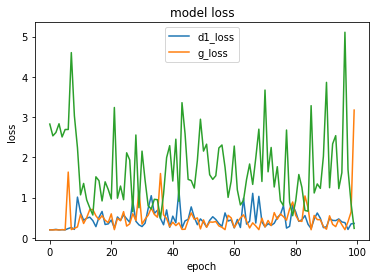

In [4]:
print(history.history.keys())
#plt.plot(history.history['d1_loss'])
#plt.plot(history.history['d2_loss'])
#plt.plot(history.history['g_loss'])
plt.plot(d1_loss_values)
plt.plot(d2_loss_values)
plt.plot(g_loss_values)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['d1_loss', 'g_loss'])
plt.show()

In [5]:
for layer in d_model.layers:
    print(layer.output_shape)


[(None, 256, 256, 3)]
(None, 128, 128, 64)
(None, 128, 128, 64)
(None, 128, 128, 64)
(None, 64, 64, 128)
(None, 64, 64, 128)
(None, 64, 64, 128)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 32, 32, 256)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 16, 16, 512)
(None, 131072)
(None, 1)


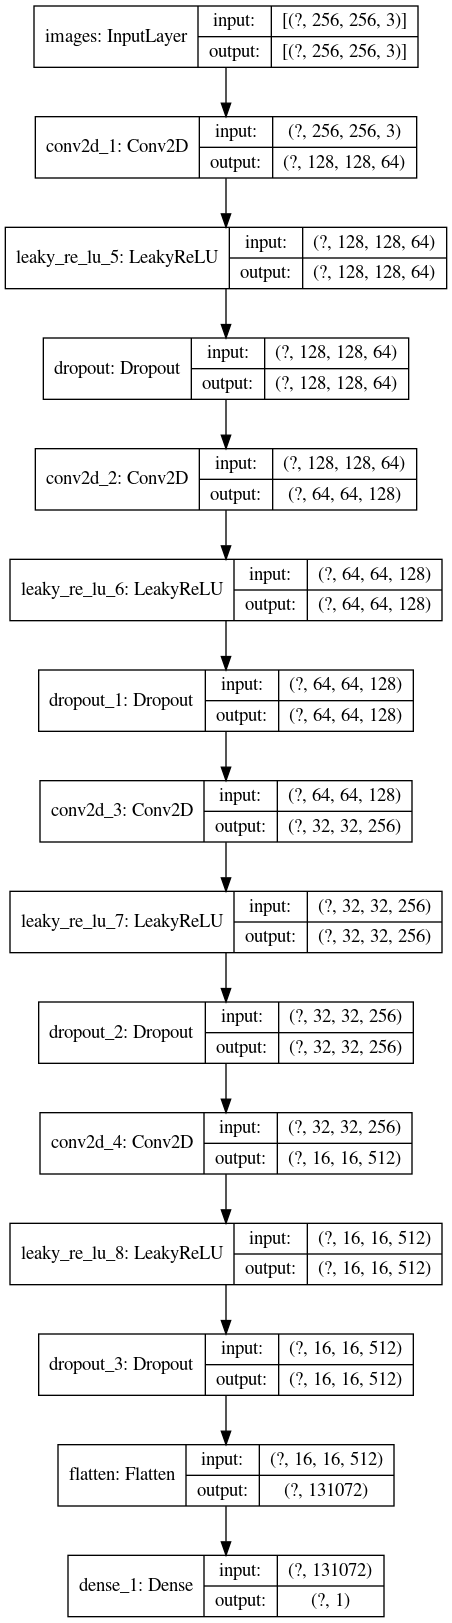

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(d_model, show_shapes=True, show_layer_names=True)

In [7]:
def calc_FID(model, images1, images2):
    #calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    
    #calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act1, rowvar=False)
    
    #calculate sum squared difference between means
    ssd_Diff = np.sum((mu1 - mu2)**2.0)
    
    #calculate sqrt of product between cov
    cov_Mean = sqrtm(sigma1.dot(sigma2))
    
    #check and correct imaginary numbers from sqrt
    if iscomplexobj(cov_Mean):
        cov_Mean = cov_Mean.real
        
    #calculate FID score
    fid_Score = ssd_Diff + trace(sigma1 + sigma2 - 2.0 * cov_Mean)
    return fid_Score

def calc_avg_FID():
    
    FID = []
    total_FID = 0
    
    #prepare the inception v3 model from keras
    #default input size 259 x 259
    model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(259,259,3))
    
    real_images_path = "../input/mriimagesrgb/MRI_RGB_IMAGES/ADNI1_002_S_0295_Wave1_Grey_brain1.png"
    g_images_path = "./images"
    r_img = load_image(real_images_path)
    r_img = tf.image.resize_images(r_img, (259, 259, 3))
    ####
    g_images = tf.data.Dataset.list_files(f"{g_images_path}*.png")
    g_images = scale_image(g_images, (259, 259, 3))
    
    
    
    #calculate FID score for each generated image
    for img in os.listdir(g_images_path):
        g_img = load_image(img)
        g_img = tf.image.resize_images(g_img, (259, 259, 3))
        
        FID.append(calc_FID(model, g_img, r_img))
    
    for score in FID:
        total_FID += score
    
    avg_FID = total_FID/len(FID)
    
    return avg_FID

def scale_image(images, new_shape):
    image_arr = []
    for image in images:
        new_image = tf.image.resize_images(image, new_shape)
        images_list.append(new_image)
    return image_arr


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


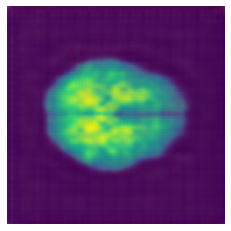

In [8]:
directory = "./models/"

for model in os.listdir(directory):
    if model.startswith("g"):
        #print(model)
        loaded_model = tf.keras.models.load_model(directory+model)  
        n_samples = 1 #number of output images to generate example: 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = loaded_model.predict(noise)
        display_img(examples, epoch, int(np.sqrt(n_samples)))